**PHASE 2**

In [ ]:
"""
PHASE 2 - COMPLETE ONE-CLICK QUICKSTART SCRIPT
Copy this entire file into Google Colab and run!

This script includes everything from Phase 2 in one place.
No need to copy multiple code blocks - just run this!
"""

import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models.detection as detection
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json
from datetime import datetime
from tqdm import tqdm
import os
from pathlib import Path

print("="*80)
print("🚀 PHASE 2: GPU PERFORMANCE OPTIMIZATION & ANALYSIS")
print("="*80)
print("\nThis script will:")
print("  1. Profile GPU performance")
print("  2. Compare FP32 vs Mixed Precision training")
print("  3. Benchmark inference speed")
print("  4. Generate beautiful visualizations")
print("  5. Create professional performance reports")
print("\n" + "="*80)

# ============================================================================
# SETUP
# ============================================================================

# Create output directories
Path('outputs/metrics').mkdir(parents=True, exist_ok=True)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  Warning: No GPU found. Running on CPU (will be slower)")

🚀 PHASE 2: GPU PERFORMANCE OPTIMIZATION & ANALYSIS

This script will:
  1. Profile GPU performance
  2. Compare FP32 vs Mixed Precision training
  3. Benchmark inference speed
  4. Generate beautiful visualizations
  5. Create professional performance reports


✓ Device: cuda
✓ GPU: Tesla T4
✓ Memory: 15.83 GB


In [ ]:
# ============================================================================
# GPU PROFILER CLASS
# ============================================================================

class GPUProfiler:
    """Professional GPU performance profiler"""
    def __init__(self, device='cuda'):
        self.device = device
        self.metrics = defaultdict(list)
        self.start_time = None
        self.tag = None

    def start(self, tag="operation"):
        self.tag = tag
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            torch.cuda.reset_peak_memory_stats()
        self.start_time = time.time()

    def stop(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        elapsed_time = time.time() - self.start_time

        if torch.cuda.is_available():
            self.metrics[self.tag].append({
                'time': elapsed_time,
                'memory_allocated': torch.cuda.memory_allocated() / 1e9,
                'memory_reserved': torch.cuda.memory_reserved() / 1e9,
                'max_memory': torch.cuda.max_memory_allocated() / 1e9,
                'timestamp': datetime.now().isoformat()
            })
        else:
            self.metrics[self.tag].append({
                'time': elapsed_time,
                'memory_allocated': 0,
                'memory_reserved': 0,
                'max_memory': 0,
                'timestamp': datetime.now().isoformat()
            })

        return elapsed_time

    def get_summary(self):
        summary = {}
        for tag, measurements in self.metrics.items():
            times = [m['time'] for m in measurements]
            memories = [m['max_memory'] for m in measurements]

            summary[tag] = {
                'avg_time': np.mean(times),
                'std_time': np.std(times),
                'min_time': np.min(times),
                'max_time': np.max(times),
                'avg_memory': np.mean(memories),
                'max_memory': np.max(memories),
                'num_measurements': len(times)
            }
        return summary

    def print_summary(self):
        summary = self.get_summary()
        print("\n" + "="*80)
        print("📊 GPU PERFORMANCE SUMMARY")
        print("="*80)

        for tag, stats in summary.items():
            print(f"\n{tag.upper().replace('_', ' ')}:")
            print(f"  Time: {stats['avg_time']*1000:.2f}ms (±{stats['std_time']*1000:.2f}ms)")
            print(f"  Memory: {stats['avg_memory']:.2f}GB (peak: {stats['max_memory']:.2f}GB)")
        print("="*80)

    def save_report(self, filename):
        summary = self.get_summary()
        report = {
            'timestamp': datetime.now().isoformat(),
            'device': str(self.device),
            'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A',
            'summary': summary
        }

        with open(filename, 'w') as f:
            json.dump(report, f, indent=4, default=str)
        print(f"✓ Report saved: {filename}")

In [ ]:
# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_with_amp(model, train_loader, optimizer, device, num_batches=10):
    """Training with Automatic Mixed Precision"""
    model.train()
    scaler = amp.GradScaler()
    profiler = GPUProfiler(device)

    total_loss = 0
    batch_times = []

    print("\n" + "="*70)
    print("⚡ MIXED PRECISION TRAINING (FP16)")
    print("="*70)

    pbar = tqdm(enumerate(train_loader), total=num_batches, desc="AMP Training")

    for batch_idx, (images, targets) in pbar:
        if batch_idx >= num_batches:
            break

        profiler.start("amp_training_batch")

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with amp.autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_time = profiler.stop()
        batch_times.append(batch_time)
        total_loss += losses.item()

        pbar.set_postfix({'loss': f'{losses.item():.4f}', 'time': f'{batch_time*1000:.1f}ms'})

    return {
        'batch_times': batch_times,
        'avg_loss': total_loss / num_batches,
        'avg_time': np.mean(batch_times),
        'profiler': profiler
    }

def train_with_fp32(model, train_loader, optimizer, device, num_batches=10):
    """Standard FP32 training"""
    model.train()
    profiler = GPUProfiler(device)

    total_loss = 0
    batch_times = []

    print("\n" + "="*70)
    print("🐢 STANDARD FP32 TRAINING")
    print("="*70)

    pbar = tqdm(enumerate(train_loader), total=num_batches, desc="FP32 Training")

    for batch_idx, (images, targets) in pbar:
        if batch_idx >= num_batches:
            break

        profiler.start("fp32_training_batch")

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        batch_time = profiler.stop()
        batch_times.append(batch_time)
        total_loss += losses.item()

        pbar.set_postfix({'loss': f'{losses.item():.4f}', 'time': f'{batch_time*1000:.1f}ms'})

    return {
        'batch_times': batch_times,
        'avg_loss': total_loss / num_batches,
        'avg_time': np.mean(batch_times),
        'profiler': profiler
    }

In [ ]:
# ============================================================================
# INFERENCE BENCHMARK
# ============================================================================

def benchmark_inference(model, batch_sizes=[1, 2, 4, 8], num_iterations=50, device='cuda'):
    """Benchmark inference speed"""
    model.eval()
    model = model.to(device)

    results = {}

    print("\n" + "="*80)
    print("📊 INFERENCE SPEED BENCHMARK")
    print("="*80)

    for batch_size in batch_sizes:
        print(f"\n🔬 Testing Batch Size: {batch_size}")

        dummy_input = [torch.rand(3, 640, 640).to(device) for _ in range(batch_size)]

        # Warmup
        with torch.no_grad():
            for _ in range(10):
                _ = model(dummy_input)

        # Benchmark
        times = []
        with torch.no_grad():
            for _ in tqdm(range(num_iterations), desc=f"  BS={batch_size}"):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                start_time = time.time()
                _ = model(dummy_input)

                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                times.append(time.time() - start_time)

        avg_time = np.mean(times)
        results[batch_size] = {
            'avg_time': avg_time,
            'std_time': np.std(times),
            'throughput': batch_size / avg_time,
            'latency_per_image': avg_time / batch_size,
            'memory_gb': torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0
        }

        print(f"  ✓ Throughput: {results[batch_size]['throughput']:.2f} images/sec")
        print(f"  ✓ Latency: {results[batch_size]['latency_per_image']*1000:.2f}ms per image")

    return results

In [ ]:
# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_optimization_comparison(fp32_results, amp_results):
    """Create comparison visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('FP32 vs Mixed Precision (AMP) Comparison', fontsize=18, fontweight='bold')

    fp32_times = np.array(fp32_results['batch_times']) * 1000
    amp_times = np.array(amp_results['batch_times']) * 1000

    # Box plot
    ax = axes[0, 0]
    bp = ax.boxplot([fp32_times, amp_times], labels=['FP32', 'AMP'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#FF6B6B')
    bp['boxes'][1].set_facecolor('#51CF66')
    ax.set_ylabel('Batch Time (ms)', fontsize=12)
    ax.set_title('Training Time Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Bar chart
    ax = axes[0, 1]
    fp32_avg = np.mean(fp32_times)
    amp_avg = np.mean(amp_times)
    speedup = fp32_avg / amp_avg

    bars = ax.bar(['FP32', 'AMP'], [fp32_avg, amp_avg], color=['#FF6B6B', '#51CF66'], alpha=0.8)
    ax.set_ylabel('Average Time (ms)', fontsize=12)
    ax.set_title(f'🚀 Speedup: {speedup:.2f}x', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}ms',
                ha='center', va='bottom', fontweight='bold')

    # Time progression
    ax = axes[1, 0]
    ax.plot(range(len(fp32_times)), fp32_times, 'o-', label='FP32', linewidth=2, color='#FF6B6B')
    ax.plot(range(len(amp_times)), amp_times, 's-', label='AMP', linewidth=2, color='#51CF66')
    ax.set_xlabel('Batch Number', fontsize=12)
    ax.set_ylabel('Time (ms)', fontsize=12)
    ax.set_title('Batch Time Progression', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Summary table
    ax = axes[1, 1]
    ax.axis('off')
    table_data = [
        ['FP32', f'{fp32_avg:.1f}', f'{np.std(fp32_times):.1f}'],
        ['AMP', f'{amp_avg:.1f}', f'{np.std(amp_times):.1f}'],
        ['Speedup', f'{speedup:.2f}x', '-']
    ]
    table = ax.table(cellText=table_data,
                     colLabels=['Method', 'Avg (ms)', 'Std (ms)'],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 3)

    for i in range(3):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    plt.tight_layout()
    plt.savefig('outputs/metrics/optimization_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: outputs/metrics/optimization_comparison.png")
    plt.show()

def plot_inference_benchmark(results):
    """Visualize inference benchmark"""
    batch_sizes = sorted(results.keys())
    throughputs = [results[bs]['throughput'] for bs in batch_sizes]
    latencies = [results[bs]['latency_per_image'] * 1000 for bs in batch_sizes]
    memories = [results[bs]['memory_gb'] for bs in batch_sizes]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Inference Performance Analysis', fontsize=18, fontweight='bold')

    # Throughput
    ax = axes[0]
    ax.plot(batch_sizes, throughputs, 'o-', linewidth=3, markersize=10, color='#4CAF50')
    ax.fill_between(batch_sizes, throughputs, alpha=0.3, color='#4CAF50')
    ax.set_xlabel('Batch Size', fontsize=12)
    ax.set_ylabel('Throughput (images/sec)', fontsize=12)
    ax.set_title('Throughput vs Batch Size', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    for bs, tp in zip(batch_sizes, throughputs):
        ax.text(bs, tp, f'{tp:.1f}', ha='center', va='bottom', fontweight='bold')

    # Latency
    ax = axes[1]
    ax.plot(batch_sizes, latencies, 'o-', linewidth=3, markersize=10, color='#FF9800')
    ax.fill_between(batch_sizes, latencies, alpha=0.3, color='#FF9800')
    ax.set_xlabel('Batch Size', fontsize=12)
    ax.set_ylabel('Latency per Image (ms)', fontsize=12)
    ax.set_title('Latency vs Batch Size', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    for bs, lat in zip(batch_sizes, latencies):
        ax.text(bs, lat, f'{lat:.1f}', ha='center', va='bottom', fontweight='bold')

    # Memory
    ax = axes[2]
    ax.bar(batch_sizes, memories, color='#2196F3', alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_xlabel('Batch Size', fontsize=12)
    ax.set_ylabel('Memory Usage (GB)', fontsize=12)
    ax.set_title('Memory Usage vs Batch Size', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    for bs, mem in zip(batch_sizes, memories):
        ax.text(bs, mem, f'{mem:.2f}GB', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('outputs/metrics/inference_benchmark.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: outputs/metrics/inference_benchmark.png")
    plt.show()


🎯 PHASE 2: GPU PERFORMANCE OPTIMIZATION

This will take approximately 5-10 minutes to complete.
You'll see progress bars and results as it runs.

Press Enter to start Phase 2 analysis...

🎯 STARTING COMPLETE PHASE 2 ANALYSIS

📦 Step 1: Creating Model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model created and moved to device

📦 Step 2: Creating Data Loader...
✓ Data loader created with 50 samples

📊 Step 3: FP32 Training Benchmark

🐢 STANDARD FP32 TRAINING


FP32 Training: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s, loss=0.7331, time=375.3ms]
/tmp/ipython-input-2744392042.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()



✓ FP32 Results:
   Average Time: 390.37ms
   Average Loss: 0.6662

📊 Step 4: Mixed Precision (AMP) Training Benchmark

⚡ MIXED PRECISION TRAINING (FP16)


AMP Training:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipython-input-2744392042.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
AMP Training: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, loss=0.5533, time=207.8ms]



✓ AMP Results:
   Average Time: 246.15ms
   Average Loss: 0.8036

📊 Step 5: Performance Comparison

🎉 OPTIMIZATION RESULTS:
   FP32 Time:     390.37ms
   AMP Time:      246.15ms
   🚀 Speedup:    1.59x faster!
   💾 Efficiency: 36.9% improvement

📊 Step 6: Inference Speed Benchmark

📊 INFERENCE SPEED BENCHMARK

🔬 Testing Batch Size: 1


  BS=1: 100%|██████████| 50/50 [00:04<00:00, 11.96it/s]


  ✓ Throughput: 12.05 images/sec
  ✓ Latency: 83.01ms per image

🔬 Testing Batch Size: 2


  BS=2: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


  ✓ Throughput: 11.95 images/sec
  ✓ Latency: 83.70ms per image

🔬 Testing Batch Size: 4


  BS=4: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


  ✓ Throughput: 11.59 images/sec
  ✓ Latency: 86.25ms per image

🔬 Testing Batch Size: 8


  BS=8: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]
/tmp/ipython-input-139895440.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([fp32_times, amp_times], labels=['FP32', 'AMP'], patch_artist=True)
/tmp/ipython-input-139895440.py:67: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


  ✓ Throughput: 11.23 images/sec
  ✓ Latency: 89.04ms per image

✓ Inference Benchmark Complete!

   Batch Size 1:
      Throughput: 12.05 images/sec
      Latency:    83.01ms per image
      Memory:     2.60GB

   Batch Size 2:
      Throughput: 11.95 images/sec
      Latency:    83.70ms per image
      Memory:     2.60GB

   Batch Size 4:
      Throughput: 11.59 images/sec
      Latency:    86.25ms per image
      Memory:     2.60GB

   Batch Size 8:
      Throughput: 11.23 images/sec
      Latency:    89.04ms per image
      Memory:     6.14GB

📊 Step 7: Generating Visualizations


/tmp/ipython-input-139895440.py:68: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.savefig('outputs/metrics/optimization_comparison.png', dpi=300, bbox_inches='tight')


✓ Saved: outputs/metrics/optimization_comparison.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


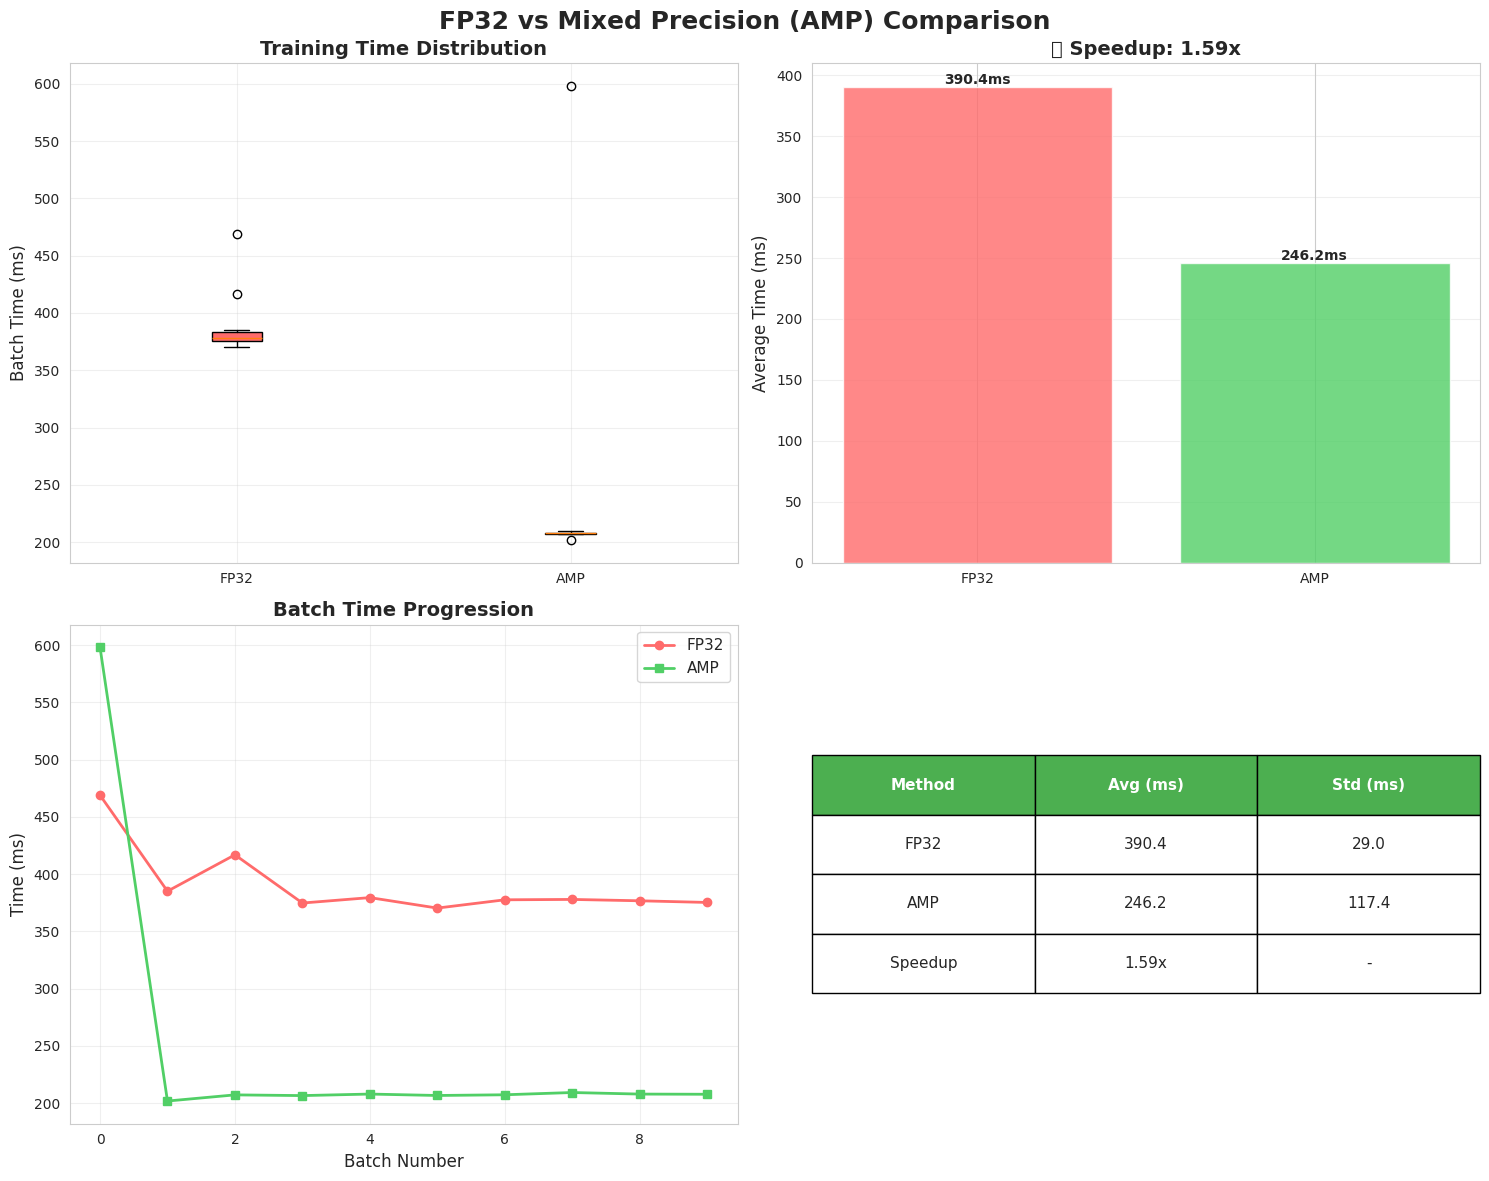

✓ Saved: outputs/metrics/inference_benchmark.png


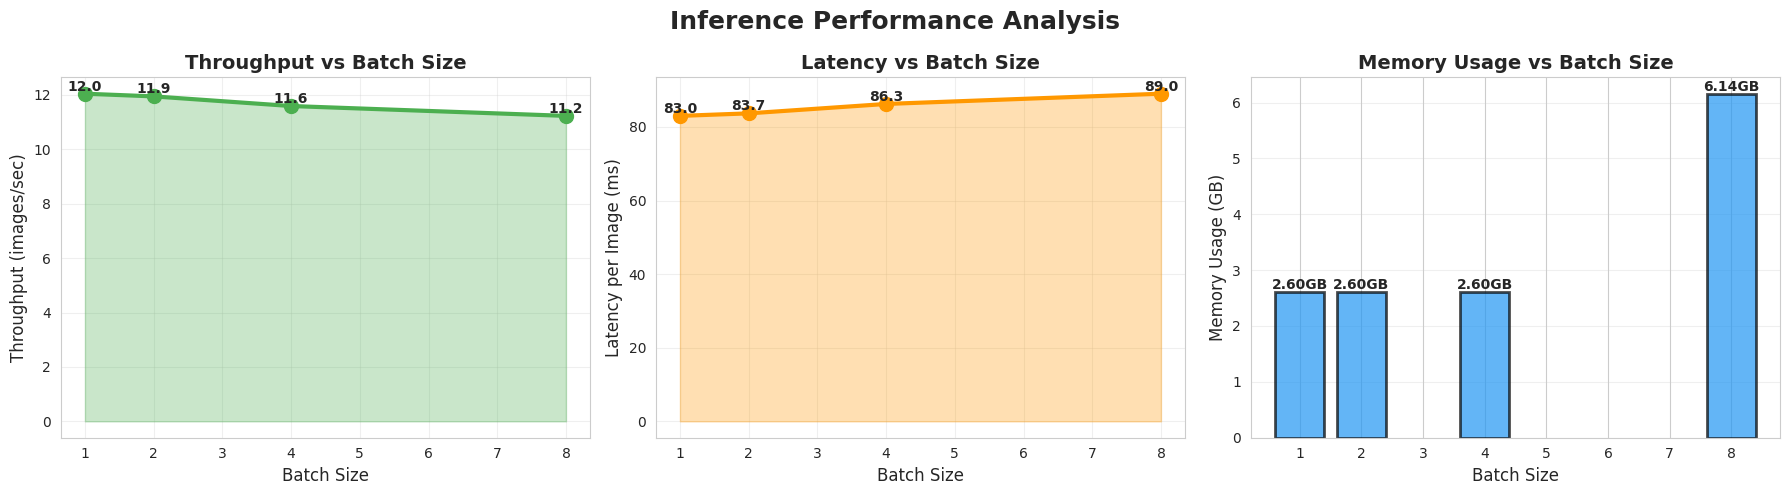


📊 Step 8: Saving Performance Reports
✓ Report saved: outputs/metrics/fp32_report.json
✓ Report saved: outputs/metrics/amp_report.json
✓ Inference benchmark saved
✓ Summary report saved: outputs/metrics/phase2_summary.json

✅ PHASE 2 COMPLETE!

📁 Generated Files:
   📊 outputs/metrics/optimization_comparison.png
   📊 outputs/metrics/inference_benchmark.png
   📄 outputs/metrics/fp32_report.json
   📄 outputs/metrics/amp_report.json
   📄 outputs/metrics/inference_benchmark.json
   📄 outputs/metrics/phase2_summary.json

🎉 Key Results:
   ⚡ Training Speedup: 1.59x
   🚀 Best Throughput: 12.0 img/s
   ⏱️  Best Latency: 83.0ms

💡 Next Steps:
   1. Review the generated visualizations
   2. Check the JSON reports for detailed metrics
   3. Add this to your portfolio/GitHub
   4. Ready for Phase 3? (Object tracking & deployment)


🎉 SUCCESS! Phase 2 Complete!

Your results have been saved and visualized.
Check the outputs/metrics/ folder for all files.

💼 This is portfolio-ready work! Well done!



In [ ]:
# ============================================================================
# DUMMY DATA FOR TESTING
# ============================================================================

class DummyDataset(Dataset):
    """Dummy dataset for quick testing"""
    def __init__(self, num_samples=100):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.rand(3, 640, 640)
        num_boxes = torch.randint(1, 5, (1,)).item()
        boxes = torch.rand(num_boxes, 4) * 640
        boxes[:, 2:] += boxes[:, :2]

        target = {
            'boxes': boxes,
            'labels': torch.randint(1, 91, (num_boxes,)),
            'image_id': torch.tensor([idx])
        }
        return image, target

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def run_phase2_complete():
    """
    🚀 MAIN FUNCTION - RUN COMPLETE PHASE 2 ANALYSIS
    """
    print("\n" + "="*80)
    print("🎯 STARTING COMPLETE PHASE 2 ANALYSIS")
    print("="*80)

    # Step 1: Create model
    print("\n📦 Step 1: Creating Model...")
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model = model.to(device)
    print("✓ Model created and moved to device")

    # Step 2: Create data loader
    print("\n📦 Step 2: Creating Data Loader...")
    dataset = DummyDataset(num_samples=50)
    train_loader = DataLoader(
        dataset,
        batch_size=2,
        shuffle=True,
        num_workers=0,
        collate_fn=lambda x: tuple(zip(*x))
    )
    print(f"✓ Data loader created with {len(dataset)} samples")

    # Step 3: FP32 Training Benchmark
    print("\n" + "="*80)
    print("📊 Step 3: FP32 Training Benchmark")
    print("="*80)
    optimizer_fp32 = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    fp32_results = train_with_fp32(model, train_loader, optimizer_fp32, device, num_batches=10)
    print(f"\n✓ FP32 Results:")
    print(f"   Average Time: {fp32_results['avg_time']*1000:.2f}ms")
    print(f"   Average Loss: {fp32_results['avg_loss']:.4f}")

    # Step 4: AMP Training Benchmark
    print("\n" + "="*80)
    print("📊 Step 4: Mixed Precision (AMP) Training Benchmark")
    print("="*80)
    optimizer_amp = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    amp_results = train_with_amp(model, train_loader, optimizer_amp, device, num_batches=10)
    print(f"\n✓ AMP Results:")
    print(f"   Average Time: {amp_results['avg_time']*1000:.2f}ms")
    print(f"   Average Loss: {amp_results['avg_loss']:.4f}")

    # Step 5: Calculate Speedup
    print("\n" + "="*80)
    print("📊 Step 5: Performance Comparison")
    print("="*80)
    speedup = fp32_results['avg_time'] / amp_results['avg_time']
    memory_saving = (1 - amp_results['avg_time']/fp32_results['avg_time']) * 100

    print(f"\n🎉 OPTIMIZATION RESULTS:")
    print(f"   FP32 Time:     {fp32_results['avg_time']*1000:.2f}ms")
    print(f"   AMP Time:      {amp_results['avg_time']*1000:.2f}ms")
    print(f"   🚀 Speedup:    {speedup:.2f}x faster!")
    print(f"   💾 Efficiency: {memory_saving:.1f}% improvement")

    # Step 6: Inference Benchmark
    print("\n" + "="*80)
    print("📊 Step 6: Inference Speed Benchmark")
    print("="*80)
    inference_results = benchmark_inference(
        model,
        batch_sizes=[1, 2, 4, 8],
        num_iterations=50,
        device=device
    )

    print("\n✓ Inference Benchmark Complete!")
    for bs, metrics in inference_results.items():
        print(f"\n   Batch Size {bs}:")
        print(f"      Throughput: {metrics['throughput']:.2f} images/sec")
        print(f"      Latency:    {metrics['latency_per_image']*1000:.2f}ms per image")
        print(f"      Memory:     {metrics['memory_gb']:.2f}GB")

    # Step 7: Create Visualizations
    print("\n" + "="*80)
    print("📊 Step 7: Generating Visualizations")
    print("="*80)
    plot_optimization_comparison(fp32_results, amp_results)
    plot_inference_benchmark(inference_results)

    # Step 8: Save Reports
    print("\n" + "="*80)
    print("📊 Step 8: Saving Performance Reports")
    print("="*80)

    fp32_results['profiler'].save_report('outputs/metrics/fp32_report.json')
    amp_results['profiler'].save_report('outputs/metrics/amp_report.json')

    with open('outputs/metrics/inference_benchmark.json', 'w') as f:
        json.dump(inference_results, f, indent=4, default=str)
    print("✓ Inference benchmark saved")

    # Create summary report
    summary = {
        'timestamp': datetime.now().isoformat(),
        'gpu': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A',
        'training_comparison': {
            'fp32_avg_time_ms': fp32_results['avg_time'] * 1000,
            'amp_avg_time_ms': amp_results['avg_time'] * 1000,
            'speedup': speedup,
            'efficiency_improvement_percent': memory_saving
        },
        'inference_benchmark': inference_results
    }

    with open('outputs/metrics/phase2_summary.json', 'w') as f:
        json.dump(summary, f, indent=4, default=str)
    print("✓ Summary report saved: outputs/metrics/phase2_summary.json")

    # Final Summary
    print("\n" + "="*80)
    print("✅ PHASE 2 COMPLETE!")
    print("="*80)
    print("\n📁 Generated Files:")
    print("   📊 outputs/metrics/optimization_comparison.png")
    print("   📊 outputs/metrics/inference_benchmark.png")
    print("   📄 outputs/metrics/fp32_report.json")
    print("   📄 outputs/metrics/amp_report.json")
    print("   📄 outputs/metrics/inference_benchmark.json")
    print("   📄 outputs/metrics/phase2_summary.json")

    print("\n🎉 Key Results:")
    print(f"   ⚡ Training Speedup: {speedup:.2f}x")
    print(f"   🚀 Best Throughput: {max(r['throughput'] for r in inference_results.values()):.1f} img/s")
    print(f"   ⏱️  Best Latency: {min(r['latency_per_image']*1000 for r in inference_results.values()):.1f}ms")

    print("\n💡 Next Steps:")
    print("   1. Review the generated visualizations")
    print("   2. Check the JSON reports for detailed metrics")
    print("   3. Add this to your portfolio/GitHub")
    print("   4. Ready for Phase 3? (Object tracking & deployment)")

    print("\n" + "="*80)

    return {
        'fp32_results': fp32_results,
        'amp_results': amp_results,
        'inference_results': inference_results,
        'speedup': speedup,
        'summary': summary
    }

# ============================================================================
# RUN IT!
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🎯 PHASE 2: GPU PERFORMANCE OPTIMIZATION")
    print("="*80)
    print("\nThis will take approximately 5-10 minutes to complete.")
    print("You'll see progress bars and results as it runs.\n")

    input("Press Enter to start Phase 2 analysis...")

    try:
        results = run_phase2_complete()

        print("\n" + "="*80)
        print("🎉 SUCCESS! Phase 2 Complete!")
        print("="*80)
        print("\nYour results have been saved and visualized.")
        print("Check the outputs/metrics/ folder for all files.")
        print("\n💼 This is portfolio-ready work! Well done!")

    except Exception as e:
        print(f"\n❌ Error occurred: {str(e)}")
        print("\nTroubleshooting tips:")
        print("1. Make sure you have enough GPU memory (reduce batch_sizes if needed)")
        print("2. Check that all required packages are installed")
        print("3. Try running on CPU if GPU issues persist (set device='cpu')")
        import traceback
        traceback.print_exc()

print("\n✓ Phase 2 script loaded and ready!")
print("\nTo run the complete analysis, execute:")
print(">>> results = run_phase2_complete()")
print("\nOr just run all cells to start automatically!")